# Calibração de Modelo Não Supervisionado de Intenções de Busca

O objetivo deste *notebook* é estruturar os recursos para ajustar a criação do modelo não supervisionado de intenções de busca considerando as intenções:
 - **Foco**: alguém com uma necessidade mais específica e que deseja encontrar a melhor opção dentre as alternativas. Por exemplo, alguém em busca de um móvel para a sala, uma *action figure* para a estante ou doces para uma festa.
 - **Exploração**: uma pessoa que pode ter um objetivo ou necessidade, mas não tem a noção de qual produto exatamente será o melor. A exemplo disso, pode-se ter alguém querendo presentear uma pessoa, mas sem a noção exata do que sera o presente ou uma pessoa que quer passar por produtos como quem visita um shopping ou feira de artesanatos, para eventualmente encontrar algo que seja de interesse.

 
O estudo para a organização da metodologia de criação do modelo foi realizado em [Análise de Intenções de Busca](04.0_Analise_de_Intencoes_de_Busca.ipynb). A partir dele, foi possível determinar as funções necessárias e os hiperparâmetros que podem controlar a qualidade da distinção das intenções, como o algoritmo de agrupamento, o número de grupos e o limiar de entropia. Considerando a necessidade de explorar o espaço de valores, registrar os resultados e permitir o reuso dos parâmetros e funções utilizados, o notebook apresenta o código refatorado e com o rastreamento das experimentações com o Mlflow.

## Bibliotecas e Funções

In [1]:
# Usado para ler arquivos, carregar código personalizado e ter acesso a outros recursos de sistema
import sys
import shutil
from pathlib import Path

# Verificação de tipos
from typing import List, Tuple, Set, Any

# Programação funcional e utilitários
import funcy as fp
import itertools
from functools import partial

# Recursos para texto
import re

# Manipulação e análise dos dados
import numpy as np
import pandas as pd

# Redução de Dimensionalidade e Análise de Similaridade
from sklearn.mixture import GaussianMixture

# Rastreamento de experimentos e modelos
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature

# Recursos para visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML, display

# Carregar, além de atualizar frequentemente, código personalizado disponível em ../src
%load_ext autoreload 
%autoreload 2
sys.path.append(str(Path.cwd().parent))
from src import settings
from src.utils.text import clean_text, load_stopwords, SPLIT_PATTERN
from src.utils.notebooks import display_side_by_side, plot_word_cloud
from src.utils.experiments import (compute_entropy,
                                   compute_multiclass_classification_metrics,
                                   format_nested_parameters)

from src.pipeline.training_pipeline import (compute_embeddings_frame,
                                            create_feature_matrix,
                                            count_frame_items,
                                            compute_frame_column_entropy,
                                            get_qualified_queries
                                           )

from src.pipeline.wrappers import UnsupervisedIntentClassificationWrapper

# Configurações para a exibição de conteúdo do Pandas e das bibliotecas gráficas
%matplotlib inline 
sns.set(rc={'figure.figsize':(25,10)})
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 150)

## Configurações de Rastreamento de Experimentos

Os parâmetros e recursos envolvidos nos experimentos serão mantidos pelo MLflow. Como o modelo é não supervisado, são registradas mais informações visuais que ajudam a entender o comportamento e a coerência do modelo.

In [2]:
EXPERIMENT_NAME = '02_UnsupervisedClassification'
EXPERIMENT_RUN_NAME = f'Structuring'

mlflow_client = MlflowClient()

# Se o experimento já não existir no MlFlow, criar um e recuperar ID
experiment = mlflow_client.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    mlflow_client.create_experiment(EXPERIMENT_NAME)
    experiment = mlflow_client.get_experiment_by_name(EXPERIMENT_NAME)

EXPERIMENT_ID = experiment.experiment_id
del experiment

## Carregamento de Dados

Para trabalhar o problema de classificação de produtos em categorias, é preciso utilizar o conjunto de dados de treinamento, dividido em  [01_Estruturacao.ipynb](01_Estruturacao.ipynb). Ainda que a análise seja não supervisonada, os dados de teste continuam isolados para evitar qualquer vazamento de informação e permitir a estimativa mais real do comportamento conjunto dos modelos com dados não vistos anteriormente.

In [3]:
columns_to_read = ['product_id', 'query', 'search_page', 'position', 'title', 'concatenated_tags', 'category', 'creation_date']

frame = pd.read_csv(str(Path(settings.DATA_PATH).joinpath('interim', 'training.csv')), usecols=columns_to_read)

## Hiperparâmetros e Funções

Os hiperparâmetros e funções utilizadas são definidos a seguir.

In [4]:
EMBEDDING_COLUMNS = ['title']
MINIMUM_NUMBER_OF_PRODUCTS = 2
ENTROPY_THRESHOLD = 0.5
CLUSTERING_MODEL = GaussianMixture
CLUSTERING_PARAMS = {'n_components': 50, 'covariance_type': 'diag'}

Agrupamento dos produtos pelo título.

In [5]:
embeddings_columns_names = [f'{item}_embedding' for item in EMBEDDING_COLUMNS]

# Create embeddings frame
embeddings_frame = pd.concat([frame, compute_embeddings_frame(frame, EMBEDDING_COLUMNS)], axis=1)

# Create a frame with individual products
products_embeddings_frame = (embeddings_frame
                             .drop_duplicates('title')
                             [['title'] + embeddings_columns_names]
                            )

# Create features array based on embeddings
X_clustering = create_feature_matrix(products_embeddings_frame,
                                     feature_columns=[],
                                     embeddings_columns=embeddings_columns_names)

# Train a clustering model and assign the cluster to products
clustering_model = CLUSTERING_MODEL(**CLUSTERING_PARAMS).fit(X_clustering)
products_embeddings_frame['cluster'] = clustering_model.predict(X_clustering)

# Assign cluster to products interacted based on a query
embeddings_frame = pd.merge(embeddings_frame, 
                            products_embeddings_frame[['title', 'cluster']], 
                            on='title', how='left')

del embeddings_columns_names

Cálculo de entropia e de métricas de consultas para análise da separação das intenções.

In [6]:
qualified_queries = get_qualified_queries(frame, MINIMUM_NUMBER_OF_PRODUCTS)

# Separar embeddings e atributos de interesse das buscas selecionadas
embeddings_entropy_frame = (embeddings_frame
                            .loc[lambda f: f['query'].isin(qualified_queries)]
                            [['query', 'cluster']]
                            .drop_duplicates('query')
                            .set_index('query')
                           )


frame_slice = embeddings_frame.loc[lambda f: f['query'].isin(qualified_queries)]

embeddings_entropy_frame = (embeddings_entropy_frame
                            .merge(count_frame_items(frame_slice, 'query', 'title').rename('distinct_products'),
                                   left_index=True, right_index=True)
                            .merge(count_frame_items(frame_slice, 'query', 'cluster').rename('distinct_clusters'),
                                   left_index=True, right_index=True)
                            .merge(compute_frame_column_entropy(frame_slice, 'query', 'cluster').rename('entropy'),
                                   left_index=True, right_index=True)
                           )

del qualified_queries, frame_slice

Distribuição de entropia das buscas.

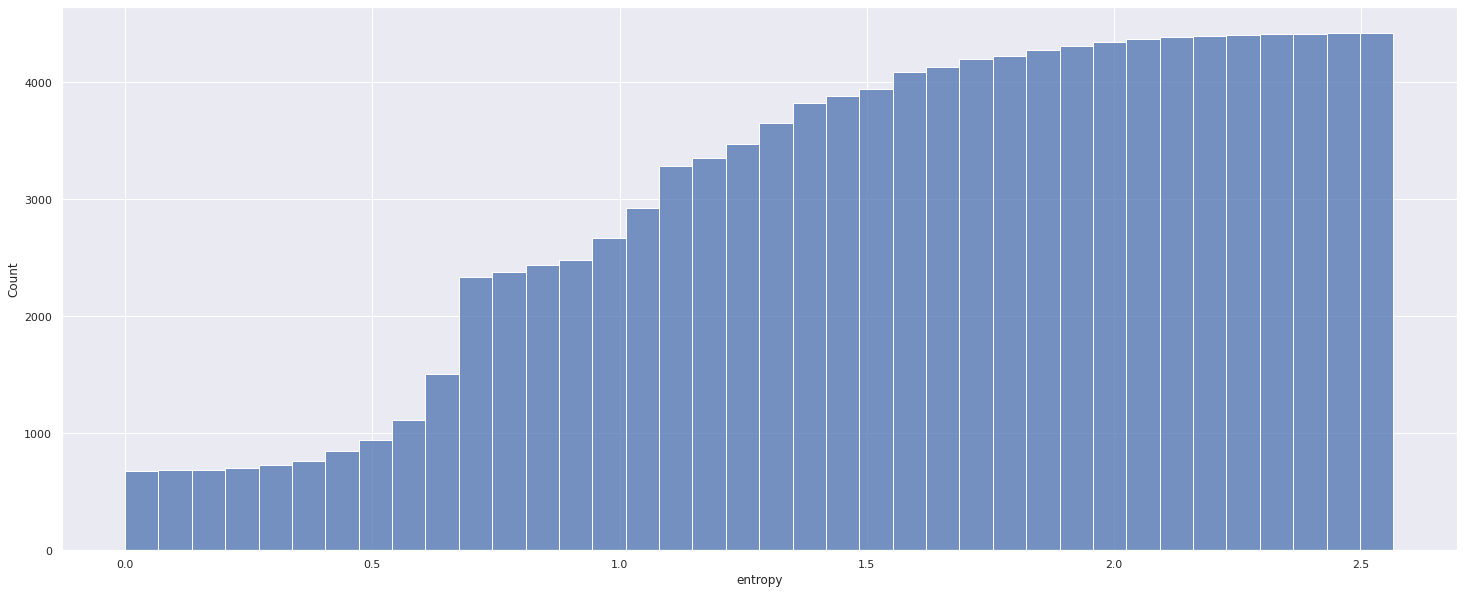

In [7]:
entropy_dist_plot = sns.histplot(embeddings_entropy_frame.loc[lambda f: f['distinct_products'] >= MINIMUM_NUMBER_OF_PRODUCTS]['entropy'], cumulative=True)

Comportamento das consultas pelos grupos de intenções.

,focused,queries,perc
0,False,3571,79.60%
1,True,915,20.40%


,query,cluster,distinct_products,distinct_clusters,entropy,focused
0,decoracao cha de bebe menina,42,5,1,0.000000,True
1,lembrancinha cha de fralda,42,7,1,0.000000,True
2,cartao de visita personalizado,10,3,1,0.000000,True
3,vasos decorativos para sala,14,5,1,0.000000,True
5,alianca ouro 24k,7,4,1,0.000000,True
6,pintura geometrica,2,4,1,0.000000,True
7,trocador de comoda,1,3,1,0.000000,True
10,caixa para bombom,4,3,1,0.000000,True
11,lembrancinhas mulher maravilha,35,2,1,0.000000,True
12,safari baby,19,1,1,0.000000,True


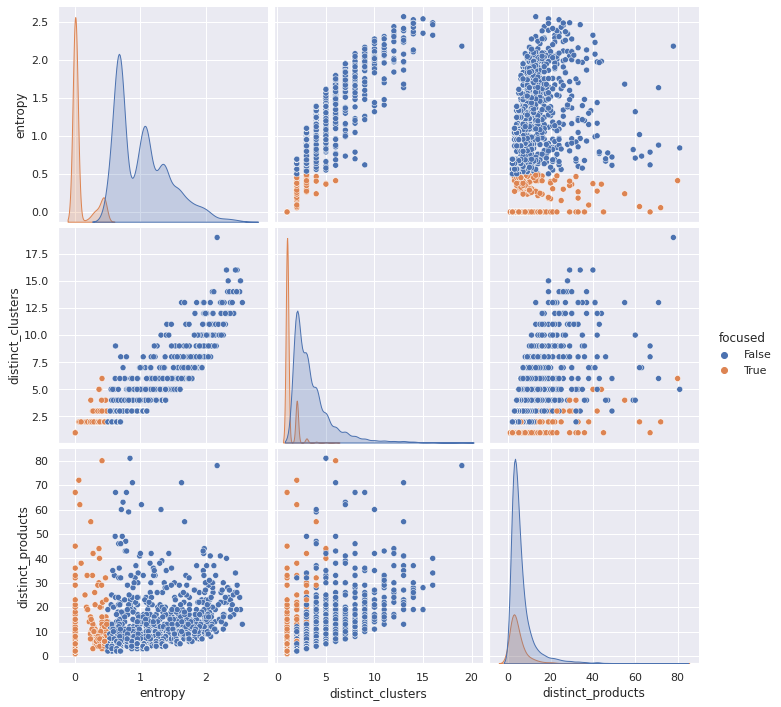

In [8]:
embeddings_entropy_frame['focused'] = embeddings_entropy_frame['entropy'] <= ENTROPY_THRESHOLD

agg_frame = (embeddings_entropy_frame
             [['focused']]
             .assign(queries=1)
             .groupby('focused')
             .sum()
             .reset_index()
             .assign(perc=lambda f: (100 * f['queries'] / f['queries'].sum()).apply(lambda v: f'{v:.2f}%'))
            )

display_side_by_side([agg_frame], ['Distribuição de Consultas por Classe'])


display(HTML('<h3>Características das Classes</h3>'))
intent_summary_plot = sns.pairplot(embeddings_entropy_frame[['entropy', 'distinct_clusters', 'distinct_products', 'focused']],
                                   height=3.33, hue='focused')


queries_to_display = 15
positive_sample = (embeddings_entropy_frame
                   .query('focused')
                   .sample(queries_to_display)
                   .reset_index()
                   .sort_values(by='entropy')
                  )
negative_sample = (embeddings_entropy_frame
                   .query('not focused')
                   .sample(queries_to_display)
                   .reset_index()
                   .sort_values(by='entropy')
                  )

display_side_by_side([positive_sample, negative_sample], ['Buscas Focadas', 'Buscas Exploratórias'])

del agg_frame

## Registrar Experimento

Organização dos recurso

In [9]:
hyperparameters = {
    'embedding_columns': EMBEDDING_COLUMNS,
    'minimum_number_of_products': MINIMUM_NUMBER_OF_PRODUCTS,
    'entropy_threshold': ENTROPY_THRESHOLD,
    'clustering_model': CLUSTERING_MODEL.__name__
}

unsupervised_intent_classification_wrapper = UnsupervisedIntentClassificationWrapper(embedding_columns=EMBEDDING_COLUMNS,
                                                                         minimum_number_of_products=MINIMUM_NUMBER_OF_PRODUCTS,
                                                                         entropy_threshold=ENTROPY_THRESHOLD,
                                                                         clustering_model=clustering_model)

Registrar informações no Mlflow

In [10]:
artifacts_path = Path(settings.LOGS_ARTIFACTS_PATH)

with mlflow.start_run(run_name=EXPERIMENT_RUN_NAME, experiment_id=EXPERIMENT_ID) as main_run:
    # A cada execução limpa o diretório de artefatos para gravar novos, a serem salvos no MLflow
    if artifacts_path.exists():
        shutil.rmtree(settings.LOGS_ARTIFACTS_PATH)
    artifacts_path.mkdir()

    # Registra parâmetros e critérios de decisão
    simple_hyperparameters_params, complex_hyperparameters_params = format_nested_parameters(hyperparameters, 'hyperparameters')
    mlflow.log_params(simple_hyperparameters_params)
    mlflow.log_params(CLUSTERING_PARAMS)

    # Registra as dimensões do vetor de características
    mlflow.log_param('X_clustering', X_clustering.shape)

    # Salva o modelo criado
    signature = infer_signature(X_clustering, products_embeddings_frame['cluster'])
    mlflow.sklearn.log_model(clustering_model, 'product_clustering_model', signature=signature)

    # Artefatos de análise
    entropy_dist_plot.figure.savefig(str(artifacts_path.joinpath('entropy_distribution.png')))
    intent_summary_plot.fig.savefig(str(artifacts_path.joinpath('intent_summary.png')))
    positive_sample.to_html(str(artifacts_path.joinpath('positive_sample.html')))
    negative_sample.to_html(str(artifacts_path.joinpath('negative_sample.html')))

    for param_name, param_value in {**complex_hyperparameters_params}.items():
        with open(str(artifacts_path.joinpath(f'{param_name}.txt')), 'w') as file:
            file.write(param_value)

    # Armazena o wrapper de pré-processamento junto com os dados do experimento
    unsupervised_intent_model_path = str(artifacts_path.joinpath('preprocessing_model'))
    mlflow.pyfunc.save_model(path=unsupervised_intent_model_path, python_model=unsupervised_intent_classification_wrapper)

    # Registra no Mlflow todos os artefatos gerados e persistidos
    mlflow.log_artifact(settings.LOGS_ARTIFACTS_PATH)

/media/bruno/f331903b-17cb-447b-b132-e6f1f08f80f8/Development/virtual_envs/teste_HT/lib/python3.8/site-packages/mlflow/models/signature.py:124: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  outputs = _infer_schema(model_output) if model_output is not None else None
